จาก [ep ที่แล้ว AI จำแนกรูปภาพ หมา แมว 37 สายพันธุ์](https://www.bualabs.com/archives/469/how-to-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-1/) เราได้ใช้ fastai version 1 ในการทำ [Image Classification](https://www.bualabs.com/archives/tag/image-classification/) ได้ผลลัพธ์แม่นยำ 94% โดยใช้เวลาเทรนเพียงแค่ไม่เกิน 5 นาที กับ Code หลัก ๆ เพียงแค่ 3 บรรทัด เวลาผ่านไปหลายเดือน ขณะนี้ fastai ออกเวอร์ชันใหม่ เป็น fastai2 มี API ที่เปลี่ยนไปเล็กน้อย เน้นความยืดหยุ่นมากขึ้น ช่วยให้เราเทรนโมเดล และข้อมูลที่มีความซับซ้อนได้อย่างสะดวกยิ่งขึ้น

เช็ค GPU ด้วย คำสั่ง [nvidia-smi](https://www.bualabs.com/archives/489/nvidia-smi-gpu-monitoring-tools-gpu-utilization-memory-usage-nvidia-hardware-ep-1/)

In [0]:
# !nvidia-smi

# 0. Magic Commands

ให้ใส่ไว้บนสุดทุก Notebook เป็นการสั่งให้ Notebook ก่อนรัน ให้รีโหลด Library ภายนอกที่เรา import ไว้ใหม่โดยอัตโนมัติ 

และให้พล็อตกราฟ matplotlib ใน Output ของ cell แบบ code ได้เลย

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Install & Import Library

ติดตั้ง fastai2 หรือ fastai version 2 และ Import Library ที่เราจะใช้ 

การ import * หมายความว่า import ทุกอย่างที่อยู่ใน package ทำให้เราไม่ได้ต้องมา import ทีละ class การ import แบบนี้ เหมาะสำหรับการทดลองอะไรใหม่ ๆ เพราะเราไม่ต้องย้อนมาแก้ import ทุกครั้งเมื่อต้องการใช้ class ใหม่ ๆ แต่ไม่แนะนำสำหรับใช้งานจริงบน Production

In [4]:
!pip install fastai2 -q

     |████████████████████████████████| 184kB 43.9MB/s 


Import 3 Package ย่อย คือ basics, vision.all, callback.all

In [0]:
from fastai2.basics import *
from fastai2.vision.all import *
from fastai2.callback.all import *

เราจะกำหนด Random Seed จะได้ผลลัพธ์ที่เหมือนกันทุกครั้ง จะได้สะดวกในการเปรียบเทียบ

In [0]:
np.random.seed(5555)

# 2. ข้อมูล

ในเคสนี้ เราจะใช้ข้อมูลจาก Oxford-IIIT Pet Dataset by O. M. Parkhi et al., 2012 ซึ่งเป็นชุดข้อมูลรูปภาพหมา 25 พันธุ์ และรูปแมว 12 พันธุ์ รวมเป็น 37 หมวดหมู่ 

อ้างอิงจากใน paper ในปี 2012 โมเดลที่ดีที่สุด สามารถทำนายพันธุ์สัตว์ ได้ถูกต้อง 59.21% โดยโมเดลนั้น ออกแบบมาเฉพาะทาง สำหรับแยกรูปสัตว์ หัวสัตว์ ตัวสัตว์ โดยเฉพาะ (สมัยนันยังไม่ใช่ Deep Learning)

เรามาดูกันว่าเราจะใช้ [Deep Learning](https://www.bualabs.com/archives/tag/deep-learning/) ทำนายพันธุ์หมาแมวจากรูป ได้ถูกต้องแม่นยำกว่าหรือไม่ 

URL ของ Dataset ที่เราจะ Download มาใช้

In [7]:
URLs.PETS

'https://s3.amazonaws.com/fast-ai-imageclas/oxford-iiit-pet.tgz'

untar_data จะดาวน์โหลดไฟล์มาเก็บไว้ แตกไฟล์ แล้ว return path ที่เก็บไฟล์เหล่านั้นไว้

In [8]:
path = untar_data(URLs.PETS)
path

Path('/root/.fastai/data/oxford-iiit-pet')

List ดูว่ามีโฟลเดอร์อะไรบ้าง

In [9]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

เข้าไป List ดูไฟล์ในโฟลเดอร์ annotations

In [10]:
(path/"annotations").ls()

(#7) [Path('/root/.fastai/data/oxford-iiit-pet/annotations/trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/README'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/xmls'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/test.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/._trimaps'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/trainval.txt'),Path('/root/.fastai/data/oxford-iiit-pet/annotations/list.txt')]

เข้าไป List ดูไฟล์ในโฟลเดอร์ images ชื่อพันธุ์จะอยู่ในชื่อไฟล์รูปภาพ

In [11]:
(path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_98.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_177.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_81.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_223.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_1.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_170.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_75.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_122.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_19.jpg')...]

# 3. เตรียมข้อมูล

ก่อนนำข้อมูลใด ๆ มาเทรน Model เราต้องมีการเตรียมข้อมูล กำหนด [Data Pipeline](https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) ให้อยู่ในรูปแบบที่เหมาะสมเสียก่อน ใน fastai2 นี้ มีการเปลี่ยนแปลง Data Pipeline จาก [fastai version 1](https://www.bualabs.com/archives/469/how-to-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-1/) หลายอย่าง จะอธิบายต่อไป

นำรายชื่อไฟล์รูปภาพทั้งหมด มาใส่ไว้ใน ตัวแปร fnames

In [12]:
fnames = get_image_files(path/"images")
fnames

(#7390) [Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_98.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_78.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/leonberger_177.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_81.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_223.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/pug_1.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_170.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_75.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_122.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Sphynx_19.jpg')...]

กำหนด Pattern ของ [Regex](https://www.bualabs.com/archives/3070/what-is-regular-expression-regex-regexp-teach-how-to-regex-python-nlp-ep-7/) สำหรับสกัดข้อมูล ชื่อสายพันธุ์ จากชื่อไฟล์รูปภาพ

In [13]:
pat = r"([^/]+)_\d+.*$"
re.findall(pat, str(fnames[0]))

['Russian_Blue']

กำหนด Data Augmentation สำหรับ การ Transformation ระดับ Item เช่น การย่อรูปภาพ การสุ่ม Crop บางส่วนของรูป การปรับสัดส่วนกว้างยาวของรูป ให้เป็นรูปขนาดเท่า ๆ กัน เพื่อส่งไป batch_tfms โดย Transformation เหล่านี้จะถูกประมวลผลบน CPU ทีละรูป 

In [0]:
item_tfms = RandomResizedCrop(460, min_scale=0.8, ratio=(1., 1.))

กำหนด [Data Augmentation](https://www.bualabs.com/archives/1170/what-is-data-augmentation-benefits-data-augmentaion-deep-learning-training-model-deep-neural-network-regularization-ep-1/) สำหรับ การ Transformation ระดับ Batch เช่น การ [Normalize](https://www.bualabs.com/archives/2100/what-is-normalization-feature-scaling-rescaling-normalization-standardization-feedforward-train-machine-learning-preprocessing-ep-2/) และ Data Augmentation ทั้ง Batch โดย Transformation เหล่านี้จะถูกประมวลผลบน [GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) เป็น Batch

In [0]:
batch_tfms = [*aug_transforms(size=224, max_warp=0.15), Normalize.from_stats(*imagenet_stats)]

?? ด้านล่างคือ help ให้ Uncomment ทีละบรรทัด แล้ว Run Cell

In [0]:
# aug_transforms??
# RandomResizedCrop??

กำหนด ขนาด [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) ที่จะ Feed ให้โมเดล

In [0]:
bs = 64

## 3.1 ImageDataLoaders

สร้าง ImageDataLoaders จากชื่อไฟล์ และ RegEx

*ใน fastai version 1 ที่เคยใช้ ImageDataBunch.from_name_re จะกลายเป็น ImageDataLoaders.from_name_re ใน fastai2*

In [0]:
dls = ImageDataLoaders.from_name_re(path, fnames, pat, bs=bs, 
                                     batch_tfms=batch_tfms, item_tfms=item_tfms)

In [0]:
# ImageDataLoaders.from_name_re??

show_batch แสดงข้อมูลรูปภาพ พร้อม Label จำนวน 1 Batch

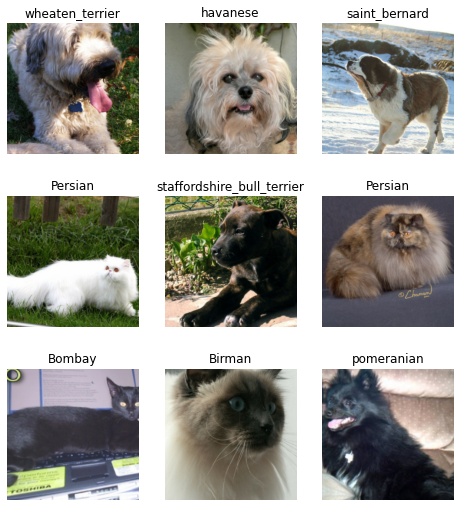

In [21]:
dls.show_batch(max_n=9, figsize=(8, 9))

## 3.2 DataBlock 

อีกวิธีหนึ่ง คือ เราสามารถ สร้าง Data Pipeline ด้วย [DataBlock API](https://www.bualabs.com/archives/2693/what-is-data-pipeline-data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/) เวอร์ชันใหม่ ที่มีความยืดหยุ่นมากกว่า ImageDataLoaders

In [0]:
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(), 
                 get_y=RegexLabeller(pat=r"/([^/]+)_\d+.*"), 
                 item_tfms=item_tfms, 
                 batch_tfms=batch_tfms)

ข้างบนเราจะใช้ RandomSplitter ในการ Split ข้อมูลใน Dataset ออกเป็น [Traning Set และ Validation Set](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/) แบบ Random โดยระบุให้ Split valid_pct 80/20 

In [24]:
splitter = RandomSplitter(valid_pct=0.2, seed=5555)
splitter(fnames)

((#5912) [5355,321,5134,134,6524,2441,4612,320,746,2333...],
 (#1478) [950,1053,979,285,440,3041,4225,3800,6844,1079...])

ได้ List แรก จำนวน 5912 Item ระบุ Index ของ fnames ที่จะอยู่ใน Training Set ส่วน List ที่สอง จำนวน 1478 Item ระบุ Index ของ fnames ที่จะอยู่ใน Validation Set

กำหนด path ของรูปภาพ

In [0]:
path_im = path/"images"

สร้าง DataLoaders จาก DataBlock ด้านบน ให้ไปอ่านไฟล์รูปภาพจาก path ที่กำหนด ด้วย [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) = bs

In [0]:
dls = pets.dataloaders(path_im, bs=bs)

แสดงข้อมูล Batch ต่อไป แต่จำกัดไว้ที่ 9 Item 

เราสามารถรัน Cell นี้ได้หลายครั้ง

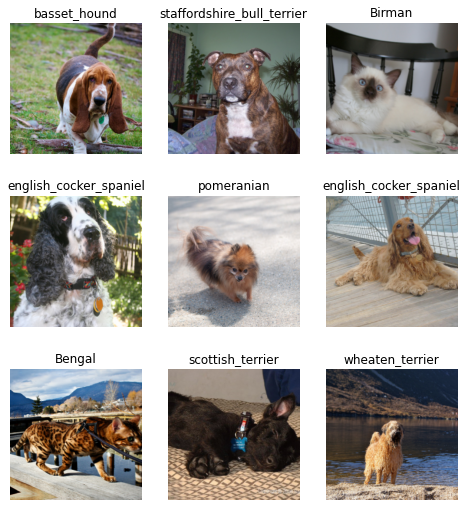

In [27]:
dls.show_batch(max_n=9, figsize=(8, 9))

Class ทั้งหมด จะถูกเก็บอยู่ใน List ชื่อ .vocab ให้เราสามารถเข้าถึงได้ตาม Index

In [28]:
dls.vocab[2]

'Birman'

In [29]:
dls.vocab

(#37) ['Abyssinian','Bengal','Birman','Bombay','British_Shorthair','Egyptian_Mau','Maine_Coon','Persian','Ragdoll','Russian_Blue'...]

ในการแปลงชื่อ Class กลับเป็นเลข Index เราสามารถใช้ Dictionary ชื่อ .vocab.o2i 

In [30]:
dls.vocab.o2i.get("Birman")

2

In [31]:
dls.vocab.o2i

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

# 4. สร้างโมเดล

สร้าง [CNN](https://www.bualabs.com/archives/2461/what-is-convolutional-neural-network-cnn-convnet-mnist-deep-learning-convnet-ep-1/) Learner ด้วยฟังก์ชัน cnn_learner ระบุ DataLoaders ของข้อมูลที่จะใช้เทรน, [Model Architecture](https://www.bualabs.com/archives/2703/how-to-read-model-convolutional-neural-network-shape-activation-map-model-architecture-convnet-ep-7/), ต้องการใช้ Pretrained Model ในการทำ [Transfer Learning](https://www.bualabs.com/archives/3493/what-is-transfer-learning-build-headless-mobilenet-model-transfer-learning-machine-learning-mobilenet-json-retrain-webcam-tensorflow-js-tfjs-ep-10/) หรือไม่, metrics การวัดผลในเคสนี้เราจะใช้ Error Rate, และ เทรนแบบ [Mixed Precision](https://www.bualabs.com/archives/3573/what-is-quantization-benefits-of-quantization-deep-neural-network-tflite-ep-2/) ด้วย .to_fp16()

In [32]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


โดย default cnn_learner จะลบ layer สุดท้ายของ model ที่ดาวน์โหลดมาทิ้งไป และแทนที่ด้วย Dense Layer ใหม่ เป็น Head ที่มี 37 Output ตรงกับ .vocab ของเรา
model จะถูก Save ไว้ที่ $HOME/.cache/torch/checkpoints/ เมื่อรันอีกครั้งจะไม่ได้ต้องดาวน์โหลดใหม่

# 5. เริ่มต้นเทรนโมเดล

ลอง fit ด้วย ค่า default จำนวน 4 epoch

* 1 [epoch](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) คือ ใช้ป้อนข้อมูล หมด Dataset 1 รอบ
* [fit_one_cycle](https://www.bualabs.com/archives/2452/schedule-hyperparameter-train-machine-learning-deep-neural-network-one-cycle-learning-rate-neural-network-ep-13/) คือ การเทรนแบบพิเศษ คือมีการ Schedule [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) เพิ่มลด ตามแต่ละช่วงของการเทรน

In [33]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.903174,0.345267,0.116373,01:03
1,0.686868,0.246993,0.079838,01:03
2,0.390674,0.209668,0.068336,01:03
3,0.288875,0.206512,0.066982,01:02


### สำเร็จแล้ว

ด้วยพลังของ [GPU](https://www.bualabs.com/archives/1426/why-gpu-require-train-deep-learning-compare-cpu-vs-gpu-deep-neural-network-hardware-ep-2/) เพียงแค่เวลาไม่ถึง 4 นาที เราเทรน Model ได้ Error Rate 0.07 หรือ Accuracy ความแม่นยำประมาณ 93%

เปรียบเทียบกับ paper เมื่อปี 2012 ที่ได้ 59.21% หรือเปรียบเทียบกับมนุษย์ คงเป็นเรื่องยาก ถ้าให้เวลาเรา 4 นาที ดูรูปหมาแมว แล้วให้ทายว่าเป็นพันธุ์อะไร 1 ใน 37 สายพันธุ์ แต่ Model [Deep Learning](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) ของเรา นี้สามารถทายได้ถูกต้องถึง 93% โดยใช้เวลาในการเรียนรู้เพียงแค่ 4 นาทีเท่านั้น

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [0]:
learn.save("01i-stage1")

# 6. ดูสถิติของโมเดล

เรามาดูกราฟ Training [Loss](https://www.bualabs.com/archives/2673/what-is-loss-function-cost-function-error-function-loss-function-how-cost-function-work-machine-learning-ep-1/) และ [Validation Loss](https://www.bualabs.com/archives/2075/validation-metrics-neural-network-validation-set-train-machine-learning-neural-network-ep-8/) ต่อจำนวน [Batch](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) ข้อมูลที่เราป้อนให้โมเดล

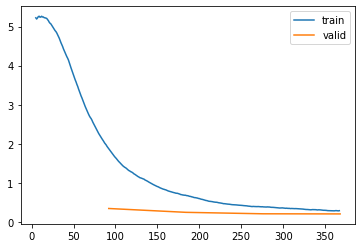

In [35]:
learn.recorder.plot_loss()

กราฟค่า lr [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) และ mom Momentum ตามจำนวน Batch / Iteration ของการเทรน จะเห็นได้ว่า Learning Rate และ Momentum ไม่คงที มีขึ้นมีลง ตั้งแต่ประมาณ 0.0003-0.001, 0.95-0.85 เป็นความพิเศษของ [fit_one_cycle](https://www.bualabs.com/archives/2452/schedule-hyperparameter-train-machine-learning-deep-neural-network-one-cycle-learning-rate-neural-network-ep-13/)

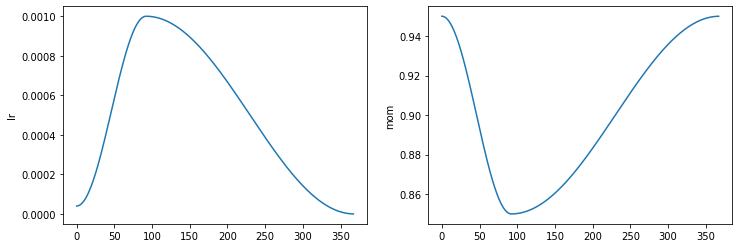

In [36]:
learn.recorder.plot_sched()

# 7. ดูผลลัพธ์

ถ้าเราดูแค่ Metrics Error Rate อย่างเดียว ว่ากี่เปอร์เซ็นต์ เราอาจจะไม่เห็นภาพว่า Model ทำงานได้ผลลัพธ์อย่างไร เราควรดูข้อมูลจริง รูปจริง Label จริง ด้วย ว่าโมเดล Predict อะไรออกมา

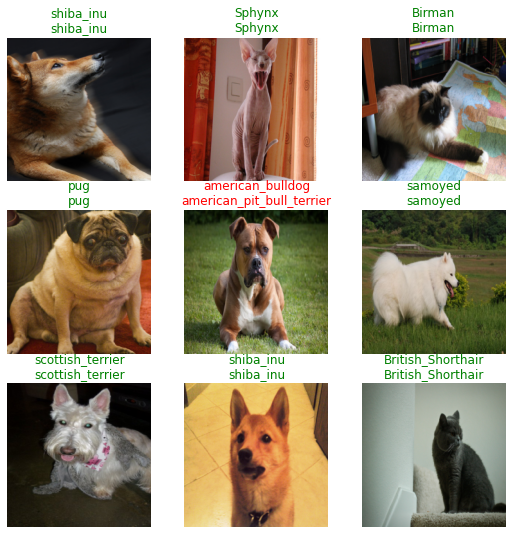

In [37]:
learn.show_results()

เราจะสร้าง ClassificationInterpretation เป็น class ที่มาช่วยตีความผลลัพธ์ ให้เราดูเข้าใจง่ายขึ้น

In [38]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

len(dls.valid_ds) == len(losses) == len(idxs)

True

เราจะดูรูปที่มีค่า Loss มากที่สุด 9 อันดับแรก หรือพูดง่าย ๆ ว่าแสดงรายการที่โมเดลทายผิด Class ด้วยความมั่นใจ (Probability) มากที่สุด 9 อันดับแรก

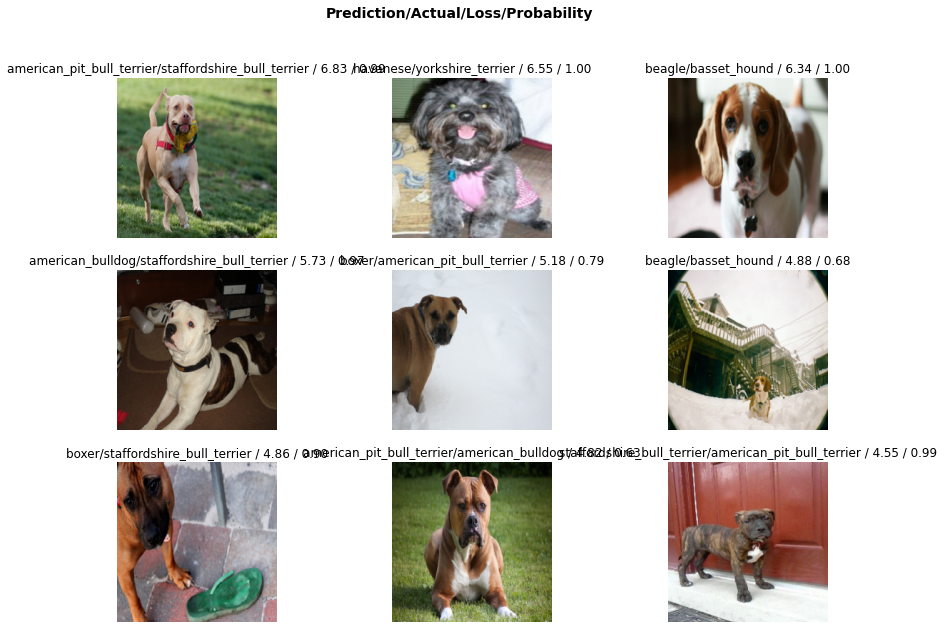

In [39]:
interp.plot_top_losses(9, figsize=(14, 10))

จะเห็นได้ว่ายากจริง ๆ เนื่องจากหมาและแมวบางพันธุ์ก็หน้าตารูปร่างใกล้เคียงกัน

สั่ง plot_confusion_matrix จะแสดงตาราง [Confusion Matrix](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) ตัดกันของหมวดหมู่ทั้งหมด 37 x 37 ว่าข้อมูลจริงคือพันธุ์อะไร (Row) แล้วโมเดลทายว่าพันธุ์อะไร (Column) สังเกตุที่ทายถูกจะเป็นเส้นแทยงมุมตรงกลาง

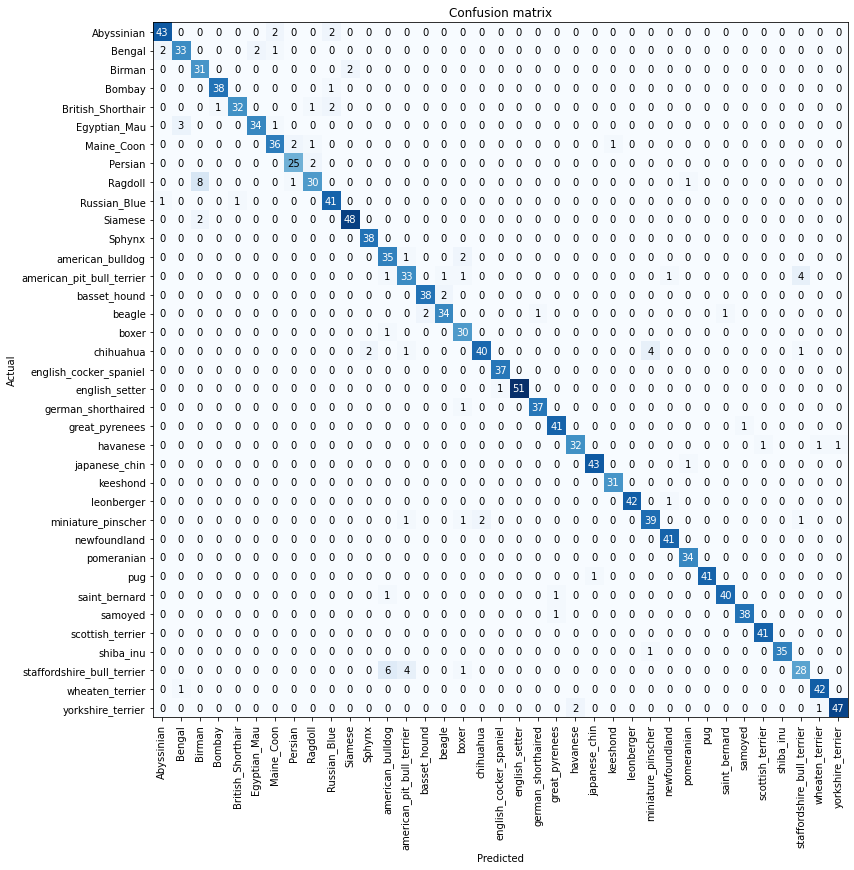

In [40]:
interp.plot_confusion_matrix(figsize=(12, 12), dpi=72)

เนื่องจาก 37 พันธุ์ เรียกว่าค่อนข้างมาก ทำให้ตารางมีขนาดใหญ่ ตัวหนังสือเลยมีขนาดเล็ก อ่านยาก แต่เราสามารถดูคราว ๆ ได้ว่าส่วนใหญ่ทายถูก มี 1 และ 2 อยู่กระจาย ๆ ไป

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [41]:
interp.most_confused(min_val=3)

[('Ragdoll', 'Birman', 8),
 ('staffordshire_bull_terrier', 'american_bulldog', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('chihuahua', 'miniature_pinscher', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4),
 ('Egyptian_Mau', 'Bengal', 3)]

เราสามารถเอาชื่อพันธุ์ไป Search Google Image ดูได้ ว่าทั้ง 2 พันธุ์หน้าตาคล้ายกันจริง ๆ

# 8. เทรนต่อ

เราจะโหลดโมเดลที่เทรนไว้ด้านบนขึ้นมาใหม่

In [42]:
learn.load("01i-stage1")

เนื่องจากโดย Default แล้ว cnn_learner ในการทำ [Transfer Learning](https://www.bualabs.com/archives/3493/what-is-transfer-learning-build-headless-mobilenet-model-transfer-learning-machine-learning-mobilenet-json-retrain-webcam-tensorflow-js-tfjs-ep-10/) จะ Freeze Layer อื่น ๆ นอกจาก Layer สุดท้ายไว้ คือจะไม่มีการเทรนต่อ ที่เราเทรนตอนแรก คือ เทรนเฉพาะ Layer สุดท้าย Head ที่สร้างใหม่เท่านั้น แต่ตอนนี้เรากำลังจะ Fine Tune หรือเทรนโดยละเอียดทั้งโมเดล โดยเทรนทุก Layer

unfreeze layer ทุก Layer ให้สามารถเทรนได้

In [0]:
learn.unfreeze()

## 8.1 ทำไมยิ่งเทรน โมเดลยิ่งทำงานแย่ลง

เราจะเทรนทั้งโมเดล ทุก Layer ไป 2 Epoch

In [44]:
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.376459,1.342534,0.388363,01:04
1,0.753851,0.432497,0.133288,01:03


แต่ผลที่ได้ โมเดลกลับทำงานได้แย่ลง เนื่องจากการ Fine Tune โมเดลใน Layer แรก ๆ ต้องการ [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) น้อยลงมาก ไม่เหมือนกับการเทรนตอนแรก ๆ ที่เราสามารถใช้ Learning Rate ค่า Default ซึ่งเท่ากับ 0.001 ได้

การใช้ Learning Rate ที่มากเกินไป ทำให้ขณะที่ [Gradient Descent](https://www.bualabs.com/archives/631/what-is-gradient-descent-in-deep-learning-what-is-stochastic-gradient-descent-sgd-optimization-ep-1/) นั้น Weight และ Bias ที่อยู่ในโมเดล มีค่ากระเด้งกระดอน ออกมาจากค่าที่เหมาะสม ทำให้โมเดลทำงานแย่ลง

## 8.2 ใช้ lr_find หา Learning Rate ที่เหมาะสม

เราจะโหลดโมเดล เวอร์ชันเดิมกลับมาใหม่

In [45]:
learn.load("01i-stage1")

unfreeze layer ทุก Layer ให้สามารถเทรนได้

In [0]:
learn.unfreeze()

[lr_find](https://www.bualabs.com/archives/2377/lr-find-best-learning-rate-train-machine-learning-model-deep-neural-network-callback-neural-network-ep-12/) ฟังก์ชันนี้ จะลองเทรนโมเดลดู โดยค่อย ๆ เพิ่ม Learning Rate ไปจนกระทั้ง [Loss](https://www.bualabs.com/archives/2673/what-is-loss-function-cost-function-error-function-loss-function-how-cost-function-work-machine-learning-ep-1/) พุ่งขึ้น เพื่อดูว่าโมเดลสามารถรับ Learning Rate ได้มากสุดเท่าไร แล้วนำมาพล็อตกราฟแสดงผลให้เราดู

SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=2.75422871709452e-06)

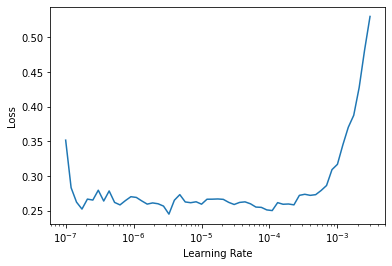

In [47]:
learn.lr_find()

เราจะเลือก ใช้ Learning Rate ที่ก่อน Loss จะพุ่งขึ้น หารด้วย 2-5

In [48]:
learn.fit_one_cycle(3, lr_max=slice(3e-7, 3e-5))

epoch,train_loss,valid_loss,error_rate,time
0,0.266368,0.204140,0.069689,01:03
1,0.270436,0.200855,0.066306,01:03
2,0.252139,0.202086,0.065629,01:03


ใช้เวลาอีก 4 นาที เราเทรน Model ได้ Error Rate 0.06 หรือ Accuracy ความแม่นยำประมาณ 94%

เนื่องจากเรากำลังเทรน [Deep Neural Networks](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) หลาย ๆ Layer พร้อม ๆ กัน แล้ว Layer แต่ละ Layer ก็ต้องการ [Learning Rate](https://www.bualabs.com/archives/618/learning-rate-deep-learning-how-to-hyperparameter-tuning-ep-1/) ที่ไม่เท่ากัน เราสามารถกำหนด Learning Rate ให้กับทุก ๆ Layer ได้ด้วยฟังก์ชัน slice ที่จะกระจายให้ทุก Layer ไล่ค่าตั้งแต่ Layer แรก = 3e-7 น้อยสุด ไป Layer สุดท้าย = 3e-5 มากสุด

แล้วลองเทรนดู ถ้าผลลัพธ์ไม่น่าพอใจก็ให้ load โมเดลใหม่ แล้วปรับ Learning Rate ลดลง 10 เท่า

เราจะเซฟโมเดลที่ Fine-Tune เรียบร้อยแล้วเก็บไว้

In [0]:
learn.save('01i-stage2')

# 9. สรุป

เราได้เรียนรู้การเทรนโมเดล [Neural Network](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) แบบ Deep Learning แบบง่าย ๆ ด้วย fastai2 ที่ได้ผลลัพธ์แม่นยำ [Accuracy](https://www.bualabs.com/archives/1968/what-is-confusion-matrix-what-is-metrics-accuracy-precision-recall-f1-score-difference-metrics-ep-1/) 93% โดยใช้เวลาเทรนเพียงแค่ไม่เกิน 4 นาที กับ Code หลัก ๆ เพียงแค่ 3 บรรทัด 

1. dls = ImageDataLoaders.from_name_re()
1. learner = cnn_learner()
1. learner.fit_one_cycle()

เปรียบเทียบกับ [fastai version 1 ใน ep ที่แล้ว](https://www.bualabs.com/archives/469/how-to-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-1/)

# 10. ของแถม ลองเทรนด้วย resnet50

เราจะลองเปลี่ยนจาก resnet34 ที่มี 34 Layer ไปใช้โมเดลที่ใหญ่มากขึ้น มีจำนวน Layer มากขึ้นถึง 50 Layer คือ [resnet50](https://www.bualabs.com/archives/482/resnet34-vs-resnet50-deep-learning-pets-cats-dogs-image-classification-with-fastai-v1-ep-2/) ดูว่าจะมีความแม่นยำมากขึ้นหรือไม่

*เวลารันโค้ดด้านล่างอาจจะต้องมีการ Restart Notebook เนื่องจาก Memory เต็ม*

In [50]:
learn = cnn_learner(dls, resnet50, pretrained=True, metrics=error_rate).to_fp16()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


ใน fastai2 มีฟังก์ชันใหม่ ที่อำนวยความสะดวกในการ Fine Tune โมเดล เมื่อเราทำ Transfer Learning 

เราไม่ต้อง Unfreeze, fit, Unfreeze, fit ทีละขั้น เราสามารถเรียก learn.fine_tune() ได้เลย

In [51]:
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,0.980389,0.322393,0.106225,01:06


epoch,train_loss,valid_loss,error_rate,time
0,0.324573,0.258172,0.077131,01:08
1,0.294191,0.315746,0.089310,01:08
2,0.245560,0.256289,0.076455,01:08
3,0.135093,0.231430,0.068336,01:08
4,0.066865,0.183090,0.054804,01:08
5,0.031890,0.181540,0.056834,01:08


ได้ Error Rate 0.05 หรือ Accuracy ประมาณ 95%

# Credit 

* https://forums.fast.ai/t/a-walk-with-fastai2-vision-study-group-and-online-lectures-megathread/59929
* https://muellerzr.github.io/fastblog/datablock/2020/03/21/DataBlockAPI.html
* [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)